In [1]:
import pandas as pd
import numpy as np
import string as str
import sklearn.metrics as met
import sklearn.model_selection as ms
import sklearn.linear_model as linmod
import seaborn as sns

/home/mukundhan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
df = pd.read_csv("export.csv")
print(df)

        CDA_RESPONSE  THER_AREA_NUM  REGION_NUM  ICON_PREF_FLG  CDA_SENT_DAY  \
0                  1              7           2              0             7   
1                  1              7           2              0             1   
2                  1              7           2              0             7   
3                  1              7           2              0             7   
4                  0              7           2              0             3   
5                  0              3           1              0             7   
6                  0              6           3              0             7   
7                  1              4           1              0             7   
8                  1              3           1              0             7   
9                  1              4           2              0             7   
10                 0              6           3              0             7   
11                 1              3     

In [22]:
print('Shape= ', df.shape)
print('------------------------------- INFO --------------------------------------------------------')
print(df.info()) #Find features which are not int/float, as they will need to be converted
print('------------------------------- DESCRIBE ------------------------------------------------------')
print(df.describe())
print('--------------------------------Nan Count -----------------------------------------------------')
print(df.isna().sum())
print('--------------------------------------------------------------------------------------------')
print('Full duplicate count= ', sum(df.duplicated()))

Shape=  (142864, 10)
------------------------------- INFO --------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142864 entries, 0 to 142863
Data columns (total 10 columns):
CDA_RESPONSE              142864 non-null int64
THER_AREA_NUM             142864 non-null int64
REGION_NUM                142864 non-null int64
ICON_PREF_FLG             142864 non-null int64
CDA_SENT_DAY              142864 non-null int64
ICON_STUDY_CNT            142864 non-null int64
OPEN_STUDIES_CNT          142864 non-null int64
STUDY_CNT                 142864 non-null int64
INV_AGE                   142864 non-null int64
PRIOR_CONTACT_RESP_CNT    142864 non-null int64
dtypes: int64(10)
memory usage: 10.9 MB
None
------------------------------- DESCRIBE ------------------------------------------------------
        CDA_RESPONSE  THER_AREA_NUM     REGION_NUM  ICON_PREF_FLG  \
count  142864.000000  142864.000000  142864.000000  142864.000000   
mean        0.5

In [3]:
#Remove full duplicate rows
df.drop_duplicates(inplace=True)

In [19]:
df.drop(columns=['STUDY_YEARS', 'ICON_STUDY_YEARS', 'PRIOR_CONTACT_NO_RESP_CNT', 'PRIOR_CONTACT_FLG'], inplace=True)

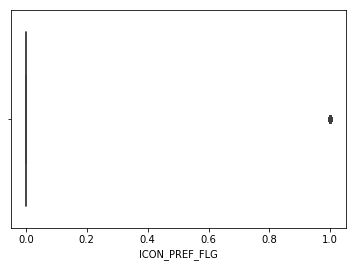

In [105]:
sns.boxplot(x=df["ICON_PREF_FLG"])

In [6]:
df['CDA_RESPONSE'].isna().sum()

0

In [20]:
for c in df.columns:
    df1 = pd.DataFrame(df[c])
    issue_flg = 0
        
    if df1[c].dtype != 'object':
        print('******** ', c, ' *********')
        q1 = df1[c].quantile(0.25)
        q3 = df1[c].quantile(0.75)
        iqr = q3 - q1
        low = q1 - (iqr * 1.5)
        high = q3 + (iqr * 1.5)
        avg = df1[c].mean()
        #print('avg= ', avg, 'low= ', low, 'upper= ', high)
        
        # Check for any negative values
        if df1[df1[c] < 0][c].count() > 0:
            issue_flg = 1
            print('\t -- Negative values exist')
            
        # Check for any Outliers
        outliers_cnt = df1[(df1[c] < low) | (df1[c] > high)][c].count()  
        if  outliers_cnt > 0:
            issue_flg = 1
            print('\t -- ', outliers_cnt, ' Outliers exist')
        
        # Check for any Nan values
        nan_cnt = df[c].isna().sum()
        if nan_cnt > 0:
            issue_flg = 1
            print('\t -- ', nan_cnt, ' NaNs exist')            
        
        # Check if any issues found with the column
        if issue_flg == 0:
            print('\t ++ No outliers or negative values or NaNs')

********  CDA_RESPONSE  *********
	 ++ No outliers or negative values or NaNs
********  THER_AREA_NUM  *********
	 ++ No outliers or negative values or NaNs
********  REGION_NUM  *********
	 ++ No outliers or negative values or NaNs
********  ICON_PREF_FLG  *********
	 --  3933  Outliers exist
********  CDA_SENT_DAY  *********
	 --  25693  Outliers exist
********  ICON_STUDY_CNT  *********
	 --  11029  Outliers exist
********  OPEN_STUDIES_CNT  *********
	 --  28437  Outliers exist
********  STUDY_CNT  *********
	 --  13390  Outliers exist
********  INV_AGE  *********
	 --  1  Outliers exist
********  PRIOR_CONTACT_RESP_CNT  *********
	 --  7272  Outliers exist


In [106]:
df.ICON_PREF_FLG.value_counts()

0    4726
1     953
Name: ICON_PREF_FLG, dtype: int64

In [7]:
df.loc[(df['OPEN_STUDIES_CNT'] > 30), 'OPEN_STUDIES_CNT1'] = 1
df.loc[(df['OPEN_STUDIES_CNT'] >= 20) & (df['OPEN_STUDIES_CNT'] < 30), 'OPEN_STUDIES_CNT1'] = 2
df.loc[(df['OPEN_STUDIES_CNT'] >= 10) & (df['OPEN_STUDIES_CNT'] < 20), 'OPEN_STUDIES_CNT1'] = 3
df.loc[(df['OPEN_STUDIES_CNT'] >= 5) & (df['OPEN_STUDIES_CNT'] < 10), 'OPEN_STUDIES_CNT1'] = 4
df.loc[(df['OPEN_STUDIES_CNT'] < 5), 'OPEN_STUDIES_CNT1'] = 5

df.drop('OPEN_STUDIES_CNT', axis='columns', inplace=True)
df.rename(columns = {'OPEN_STUDIES_CNT1':'OPEN_STUDIES_CNT'}, inplace=True)  

In [8]:
df.loc[(df['STUDY_CNT'] > 100), 'STUDY_CNT1'] = 6
df.loc[(df['STUDY_CNT'] >= 50) & (df['STUDY_CNT'] < 100), 'STUDY_CNT1'] = 5
df.loc[(df['STUDY_CNT'] >= 25) & (df['STUDY_CNT'] < 50), 'STUDY_CNT1'] = 4
df.loc[(df['STUDY_CNT'] >= 10) & (df['STUDY_CNT'] < 25), 'STUDY_CNT1'] = 3
df.loc[(df['STUDY_CNT'] >= 5) & (df['STUDY_CNT'] < 10), 'STUDY_CNT1'] = 2       
df.loc[(df['STUDY_CNT'] < 5), 'STUDY_CNT1'] = 1

df.drop('STUDY_CNT', axis='columns', inplace=True)
df.rename(columns = {'STUDY_CNT1': 'STUDY_CNT'}, inplace=True)

In [9]:
df.loc[(df['ICON_STUDY_CNT'] > 30), 'ICON_STUDY_CNT1'] = 6
df.loc[(df['ICON_STUDY_CNT'] >= 20) & (df['ICON_STUDY_CNT'] < 30), 'ICON_STUDY_CNT1'] = 5
df.loc[(df['ICON_STUDY_CNT'] >= 15) & (df['ICON_STUDY_CNT'] < 20), 'ICON_STUDY_CNT1'] = 4
df.loc[(df['ICON_STUDY_CNT'] >= 10) & (df['ICON_STUDY_CNT'] < 15), 'ICON_STUDY_CNT1'] = 3
df.loc[(df['ICON_STUDY_CNT'] >= 5) & (df['ICON_STUDY_CNT'] < 10), 'ICON_STUDY_CNT1'] = 2       
df.loc[(df['ICON_STUDY_CNT'] < 5), 'ICON_STUDY_CNT1'] = 1

df.drop('ICON_STUDY_CNT', axis='columns', inplace=True)
df.rename(columns = {'ICON_STUDY_CNT1': 'ICON_STUDY_CNT'}, inplace=True)

In [10]:
df.loc[(df['INV_AGE'] > 100), 'INV_AGE1'] = 1
df.loc[(df['INV_AGE'] >= 75) & (df['INV_AGE'] < 100), 'INV_AGE1'] = 2
df.loc[(df['INV_AGE'] >= 50) & (df['INV_AGE'] < 75), 'INV_AGE1'] = 3
df.loc[(df['INV_AGE'] >= 40) & (df['INV_AGE'] < 30), 'INV_AGE1'] = 4
df.loc[(df['INV_AGE'] >= 30) & (df['INV_AGE'] < 20), 'INV_AGE1'] = 5
df.loc[(df['INV_AGE'] >= 20) & (df['INV_AGE'] < 10), 'INV_AGE1'] = 6
df.loc[(df['INV_AGE'] >= 7) & (df['INV_AGE'] < 10), 'INV_AGE1'] = 7
df.loc[(df['INV_AGE'] >= 4) & (df['INV_AGE'] < 7), 'INV_AGE1'] = 8
df.loc[(df['INV_AGE'] < 4), 'INV_AGE1'] = 9

df.drop('INV_AGE', axis='columns', inplace=True)
df.rename(columns = {'INV_AGE1': 'INV_AGE'}, inplace=True)

In [11]:
df.loc[(df['PRIOR_CONTACT_RESP_CNT'] > 25), 'PRIOR_CONTACT_RESP_CNT1'] = 5
df.loc[(df['PRIOR_CONTACT_RESP_CNT'] >= 15) & (df['PRIOR_CONTACT_RESP_CNT'] < 25), 'PRIOR_CONTACT_RESP_CNT1'] = 4
df.loc[(df['PRIOR_CONTACT_RESP_CNT'] >= 10) & (df['PRIOR_CONTACT_RESP_CNT'] < 15), 'PRIOR_CONTACT_RESP_CNT1'] = 3
df.loc[(df['PRIOR_CONTACT_RESP_CNT'] >= 5) & (df['PRIOR_CONTACT_RESP_CNT'] < 10), 'PRIOR_CONTACT_RESP_CNT1'] = 2
df.loc[(df['PRIOR_CONTACT_RESP_CNT'] < 5), 'PRIOR_CONTACT_RESP_CNT1'] = 1

df.drop('PRIOR_CONTACT_RESP_CNT', axis='columns', inplace=True)
df.rename(columns = {'PRIOR_CONTACT_RESP_CNT1': 'PRIOR_CONTACT_RESP_CNT'}, inplace=True)

In [12]:
df.drop(columns=['STUDY_YEARS', 'ICON_STUDY_YEARS', 'PRIOR_CONTACT_NO_RESP_CNT', 'PRIOR_CONTACT_FLG'], inplace=True)

In [122]:
df['INV_AGE'].fillna(df['INV_AGE'].mode()[0], inplace=True)
df['OPEN_STUDIES_CNT'].fillna(df['OPEN_STUDIES_CNT'].mode()[0], inplace=True)
df['STUDY_CNT'].fillna(df['STUDY_CNT'].mode()[0], inplace=True)
df['ICON_STUDY_CNT'].fillna(df['ICON_STUDY_CNT'].mode()[0], inplace=True)
df['PRIOR_CONTACT_RESP_CNT'].fillna(df['PRIOR_CONTACT_RESP_CNT'].mode()[0], inplace=True)

In [149]:
df1 = np.log(df.loc[:, 'THER_AREA_NUM'])

/home/mukundhan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [151]:
df.corr()

,CDA_RESPONSE,THER_AREA_NUM,REGION_NUM,ICON_PREF_FLG,CDA_SENT_DAY,OPEN_STUDIES_CNT,STUDY_CNT,ICON_STUDY_CNT,INV_AGE,PRIOR_CONTACT_RESP_CNT
CDA_RESPONSE,1.000000,0.020344,-0.000445,0.045744,-0.023184,0.038137,0.000339,0.057460,0.036561,0.106936
THER_AREA_NUM,0.020344,1.000000,-0.001265,0.005324,-0.063043,-0.242601,0.111778,-0.051836,0.020838,0.018808
REGION_NUM,-0.000445,-0.001265,1.000000,-0.102961,-0.053215,0.064205,-0.143209,-0.244184,-0.046297,-0.095844
ICON_PREF_FLG,0.045744,0.005324,-0.102961,1.000000,0.081964,0.087023,-0.083816,-0.052416,0.039278,-0.099493
CDA_SENT_DAY,-0.023184,-0.063043,-0.053215,0.081964,1.000000,-0.042939,0.086069,0.169578,0.013334,0.148065
OPEN_STUDIES_CNT,0.038137,-0.242601,0.064205,0.087023,-0.042939,1.000000,-0.354618,-0.007320,-0.112590,-0.005343
STUDY_CNT,0.000339,0.111778,-0.143209,-0.083816,0.086069,-0.354618,1.000000,0.351591,0.289871,0.138170
ICON_STUDY_CNT,0.057460,-0.051836,-0.244184,-0.052416,0.169578,-0.007320,0.351591,1.000000,0.235935,0.384151
INV_AGE,0.036561,0.020838,-0.046297,0.039278,0.013334,-0.112590,0.289871,0.235935,1.000000,0.203629
PRIOR_CONTACT_RESP_CNT,0.106936,0.018808,-0.095844,-0.099493,0.148065,-0.005343,0.138170,0.384151,0.203629,1.000000


ValueError: range parameter must be finite.

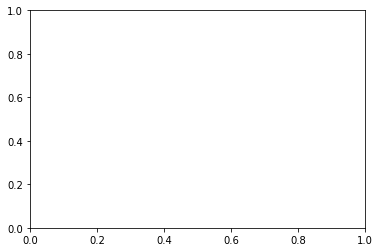

In [150]:
from sklearn.preprocessing import RobustScaler
rob_X = RobustScaler()
X_train = rob_X.fit_transform(X_train)

In [135]:
xcols = ['THER_AREA_NUM', 'REGION_NUM', 'ICON_PREF_FLG', 'CDA_SENT_DAY', 'OPEN_STUDIES_CNT', 
         'STUDY_CNT', 'ICON_STUDY_CNT', 'INV_AGE', 'PRIOR_CONTACT_RESP_CNT']

ycol = ['CDA_RESPONSE']

x = df[xcols]
y = df[ycol]

In [136]:
x_train, x_test, y_train, y_test = cv.train_test_split(x, y, test_size=0.3, random_state=0)

In [137]:
x_train.isna().sum()

THER_AREA_NUM             0
REGION_NUM                0
ICON_PREF_FLG             0
CDA_SENT_DAY              0
OPEN_STUDIES_CNT          0
STUDY_CNT                 0
ICON_STUDY_CNT            0
INV_AGE                   0
PRIOR_CONTACT_RESP_CNT    0
dtype: int64

In [138]:
logreg = linmod.LogisticRegression()
logreg.fit(x_train, y_train)

/home/mukundhan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [140]:
y_pred = logreg.predict(x_test)
print('Accuracy= ', logreg.score(x_test, y_test))

Accuracy=  0.5563380281690141


In [141]:
print(met.confusion_matrix(y_test, y_pred))

[[187 579]
 [177 761]]
